# Quantum Computing — Assignment 2 (Sheet #2)  
# Ahmed Khaled 232000046 to Dr. Norhan
## Q14: Implement Grover’s Algorithm Circuit (3 Qubits) to Mark \(|010\rangle\)

**Goal:** Build the quantum circuit that amplifies the probability of measuring the marked basis state  010  using Grover’s search on 8 States (One MARKED)



## 1) Setup & Imports

We will:
- Build the oracle that applies a **phase flip** to the marked state 010
- Build the **diffuser** (inversion about the mean)
- Compose the Grover iteration and test it on a simulator


In [ ]:
# !pip install qiskit qiskit-aer matplotlib
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


 
 everything needed to **build**, **simulate**, and **visualize** the Grover circuit.


## 2) Core Building Block: CCZ Gate

Grover’s oracle and diffuser both use a multi-qubit phase flip.  
For 3 qubits, a convenient primitive is **CCZ** (controlled-controlled-Z), which flips the phase of \(|111\rangle\).

Implementation trick:
\[
\mathrm{CCZ}(a,b,c) = H(c)\, \mathrm{CCX}(a,b,c)\, H(c)
\]


In [3]:
def ccz(qc: QuantumCircuit, a: int, b: int, c: int):
    """Apply a CCZ gate on qubits (a, b, c) using H + CCX + H."""
    qc.h(c)
    qc.ccx(a, b, c)
    qc.h(c)

### Quick sanity check (optional)
draw a tiny circuit that contains CCZ, just to confirm the decomposition is valid.


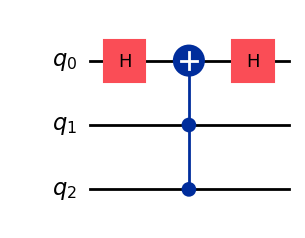

In [4]:
qc_test = QuantumCircuit(3)
ccz(qc_test, 2, 1, 0)
qc_test.draw("mpl")

### Conclusio
We now have a reusable **CCZ** function, which is the key ingredient for both the oracle and diffuser.


## 3) Oracle for the Marked State 010




In [ ]:
def oracle_mark_010(qc: QuantumCircuit, q2=2, q1=1, q0=0):
    """Phase-flip the marked state |q2 q1 q0> = |010>."""
    # Turn |010> into |111>
    qc.x(q2)  # because q2 should be 0
    qc.x(q0)  # because q0 should be 0

    # Flip the phase of |111>
    ccz(qc, q2, q1, q0)

    # Undo the conversion
    qc.x(q2)
    qc.x(q0)

### Oracle visualization


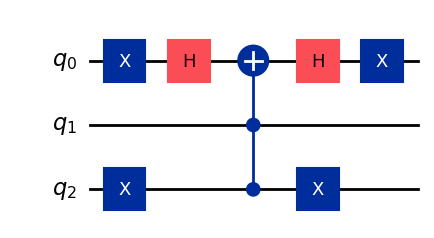

In [6]:
qc_oracle = QuantumCircuit(3)
oracle_mark_010(qc_oracle)
qc_oracle.draw("mpl")

### Conclusio
We implemented an oracle that **marks exactly one basis state**: 010 gets a minus sign (phase flip).


## 4) Diffuser (Inversion About the Mean) for 3 Qubits

The diffuser reflects the state vector around the uniform superposition \(|s\rangle\).  
Standard construction:

1. Apply \(H\) to all qubits  
2. Apply \(X\) to all qubits  
3. Apply a phase flip to 111 (via CCZ)  
4. Apply \(X\) to all qubits  
5. Apply \(H\) to all qubits


In [7]:
def diffuser_3(qc: QuantumCircuit, qubits=(0,1,2)):
    """3-qubit Grover diffuser (inversion about mean)."""
    qc.h(qubits)
    qc.x(qubits)
    # Phase flip |111>
    ccz(qc, 2, 1, 0)
    qc.x(qubits)
    qc.h(qubits)


### Diffuser visualization


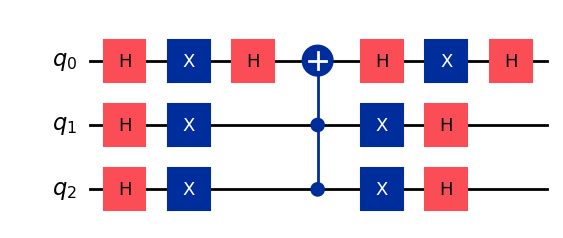

In [8]:
qc_diff = QuantumCircuit(3)
diffuser_3(qc_diff)
qc_diff.draw("mpl")

### Conclusion
We implemented the 3-qubit Grover diffuser, which performs the reflection needed to amplify the marked state.

## 5) Build the Full Grover Circuit

Grover circuit structure:
1. Prepare  | s > with Hadamards on all qubits
2. Repeat **Grover iteration** \(k\) times:
   - Oracle
   - Diffuser
3. Measure

For \(N=8\), the best amplification is usually around k = 2 iterations.


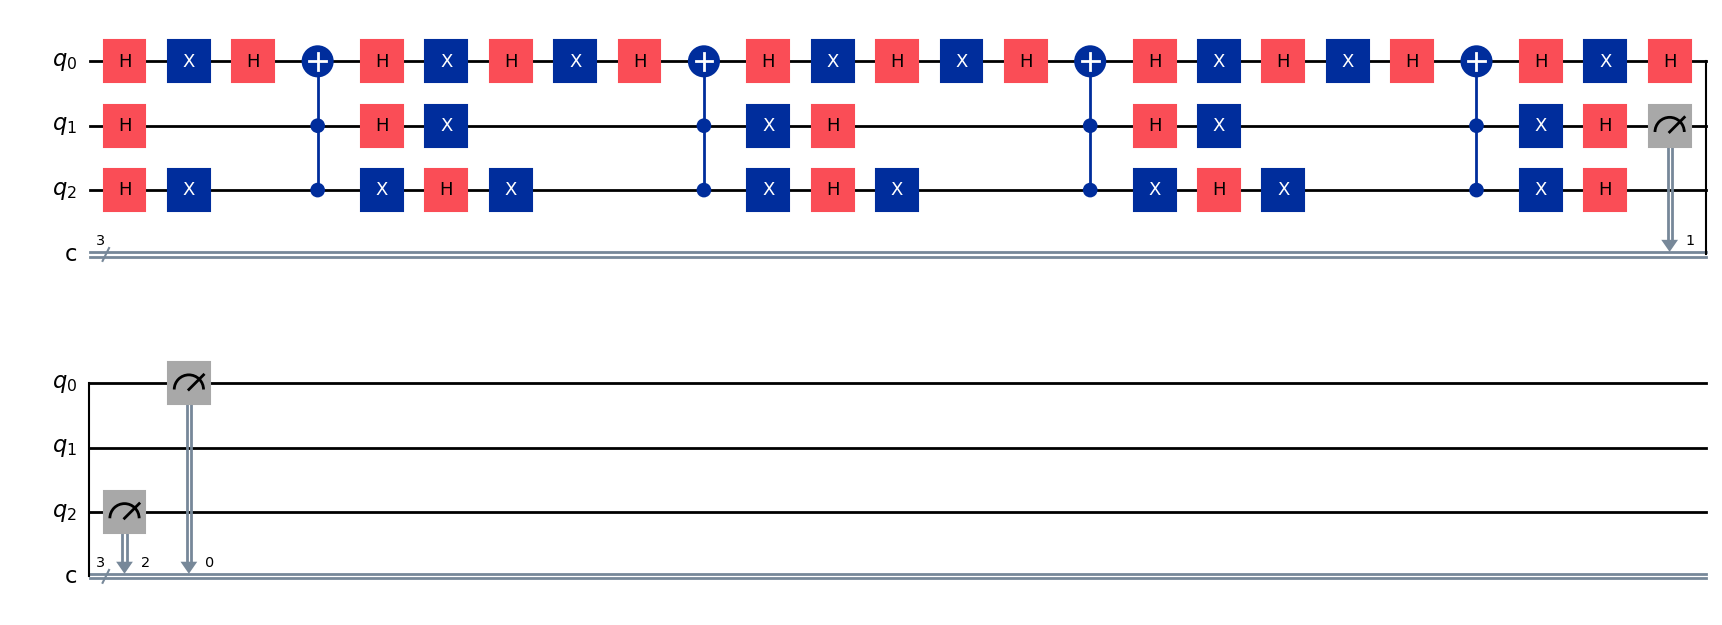

In [9]:
def grover_3qubits_mark_010(k_iters=2):
    qc = QuantumCircuit(3, 3)

    # 1) Uniform superposition
    qc.h([0,1,2])

    # 2) Grover iterations
    for _ in range(k_iters):
        oracle_mark_010(qc, q2=2, q1=1, q0=0)
        diffuser_3(qc, qubits=(0,1,2))

    # 3) Measure
    qc.measure([0,1,2], [0,1,2])
    return qc

qc_grover = grover_3qubits_mark_010(k_iters=2)
qc_grover.draw("mpl")


### Conclusion
We now have a complete Grover circuit (oracle + diffuser) configured to amplify 010

## 6) Simulate and Inspect the Measurement Results

We will run the circuit on Aer’s `qasm_simulator` and plot a histogram.

**Expected:** For 2 iterations, \(|010\rangle\) should dominate the distribution.


In [13]:
backend = Aer.get_backend("qasm_simulator")

tqc = transpile(qc_grover, backend)
job = backend.run(tqc, shots=4096)
result = job.result()
counts = result.get_counts()

counts

{'111': 26,
 '011': 28,
 '001': 33,
 '110': 40,
 '100': 34,
 '101': 29,
 '000': 36,
 '010': 3870}

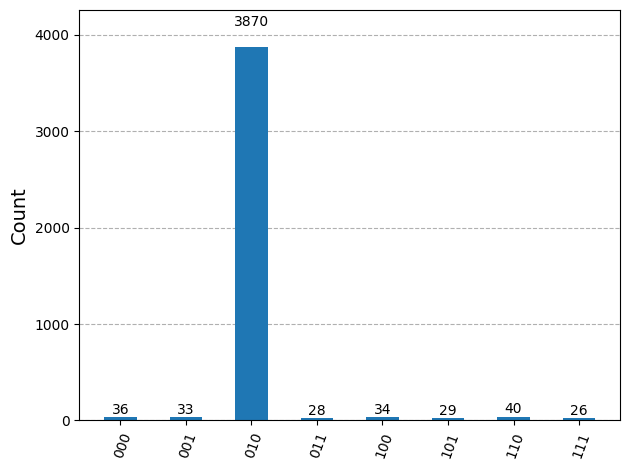

In [14]:
plot_histogram(counts)

### Conclusion
the bitstring **010** should have the highest count (largest bar), meaning Grover amplified the marked state.


# Compare 0, 1, 2, 3 Iterations

Grover “oscillates”: after too many iterations, the success probability decreases again.
We’ll simulate multiple iteration counts to see this effect.


In [27]:
def run_counts_for_k(k, shots=4096):
    qc = grover_3qubits_mark_010(k_iters=k)
    tqc = transpile(qc, backend)
    res = backend.run(tqc, shots=shots).result()
    return res.get_counts()

all_counts = {k: run_counts_for_k(k) for k in [0,1,2,3]}
all_counts


{0: {'110': 513,
  '001': 512,
  '100': 481,
  '000': 517,
  '010': 506,
  '101': 532,
  '011': 518,
  '111': 517},
 1: {'101': 110,
  '110': 142,
  '001': 112,
  '100': 142,
  '111': 133,
  '011': 132,
  '000': 133,
  '010': 3192},
 2: {'101': 37,
  '110': 25,
  '001': 28,
  '100': 25,
  '111': 37,
  '011': 28,
  '000': 31,
  '010': 3885},
 3: {'111': 421,
  '011': 380,
  '101': 375,
  '100': 379,
  '001': 373,
  '110': 396,
  '010': 1381,
  '000': 391}}

In [29]:
for k in [0,1,2,3]:
    print(f"\n=== k = {k} iterations ===")
    display(all_counts[k])
    plot_histogram(all_counts[k])


=== k = 0 iterations ===


{'110': 513,
 '001': 512,
 '100': 481,
 '000': 517,
 '010': 506,
 '101': 532,
 '011': 518,
 '111': 517}


=== k = 1 iterations ===


{'101': 110,
 '110': 142,
 '001': 112,
 '100': 142,
 '111': 133,
 '011': 132,
 '000': 133,
 '010': 3192}


=== k = 2 iterations ===


{'101': 37,
 '110': 25,
 '001': 28,
 '100': 25,
 '111': 37,
 '011': 28,
 '000': 31,
 '010': 3885}


=== k = 3 iterations ===


{'111': 421,
 '011': 380,
 '101': 375,
 '100': 379,
 '001': 373,
 '110': 396,
 '010': 1381,
 '000': 391}

### Conclusion
You should observe:
- **k=0:** nearly uniform distribution  
- **k=1:** big boost for **010**  
- **k=2:** usually the strongest boost for **010** (near-optimal for N=8)  
- **k=3:** probability can start dropping again (overshoot)


## Final Summary

implemented Q14’s Grover circuit for 3 qubits with marked state |010> by composing:

- **Oracle:** X on the 0-bits → CCZ → undo X  
- **Diffuser:** H-all → X-all → CCZ → X-all → H-all  
- Repeated the Grover iteration \(k\) times (typically \(k=2\) for \(N=8\))


# Thank You